# Optimal Portfolio Example
A basic strategy of portfolio selection is to simultaneously maximize return while minimizing risk. A portfolio of several risky securities along with one risk-free security is typically constrained by the "capital market line." This line, often ploted as tangent to the "efficient frontier" represents all optimal portfolio choices, in the sense that each portfolio along this line represents the portfolio with the lowest risk (volatility) for its expected return.

First, some essential libraries:

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.interpolate as sci

We'll start by looking at portfolios of 5 highly traded securities from several years ago. The data for these securities was take from 2010-04-01 to 2014-09-12. After struggling to find a reliable API for accessing ticker data, I resulted to manually downloading historical data from yahoo! finance and directly storing it on my computer.

In [83]:
symbols = ['AMZN', 'MSFT', 'YHOO', 'DB', 'GLD']
noa = len(symbols) # number of assets

# Set path of dowloaded data
path = '/Users/AdamFrewin/Desktop/finance/2010-04-01 to 2014-09-12/'
data = pd.DataFrame()
for sym in symbols:
    # For each security, we import the daily close prices as a new column
    data[sym] = pd.read_csv(path + sym + '.csv', header=0, index_col=0)['Close']
# to give you a sense of what this data looks like:
data.head()

,AMZN,MSFT,YHOO,DB,GLD
Date,,,,,
2010-04-01,131.809998,29.16,16.290001,74.856873,110.260002
2010-04-05,131.490005,29.27,16.510000,75.639313,110.889999
2010-04-06,135.559998,29.32,16.920000,74.723282,111.029999
2010-04-07,134.869995,29.35,16.870001,72.862595,112.489998
2010-04-08,140.960007,29.92,17.350000,72.566795,112.650002


To better visualize this data set, lets plot the normalized returns over the time interval

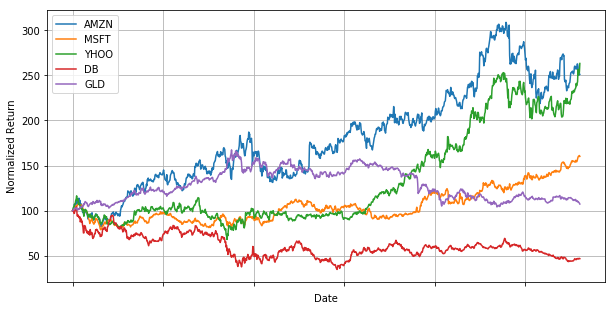

In [100]:
(data / data.iloc[0] * 100).plot(figsize=(10,5)) # historical normalized returns
plt.ylabel('Normalized Return')
plt.grid()

Clearly some of these assets performed better over these years than others. However we are not only interested in a high potential return, but also low risk, i.e. low variance. For starters lets look at some randomly assembled portfolios, their risks and expected returns. Initially we do not consider a risk-free asset available

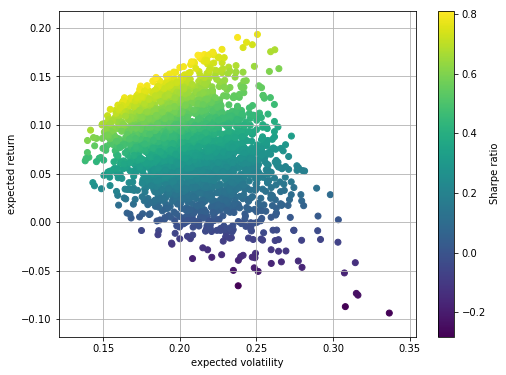

In [85]:
rets = np.log(data / data.shift(1)) # compute logarithmic returns
# Use random simulation to generate random portfolio weights on a large scale
prets = [] # stores returns
pvols = [] # stores volatilities
for p in range(2500):
    weights = np.random.random(noa) # random weights on stock purchases
    weights /= np.sum(weights) # normalize the weights to add up to 1
    prets.append(np.sum(rets.mean() * weights) * 252) # expected returns, annualized
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))) # expected variance, annualized
    
prets = np.array(prets) # convert to NumPy array
pvols = np.array(pvols)

# Plot the portfolios
plt.figure(figsize=(8,6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.grid()

Note here that the color scheme corresponds to the Sharpe ratio, the ratio of expected return to expected volatility (considering no risk-free rate), effectively a measure of the "quality" of the portfolio. A portfolio with high risk but high expected return could have a similar Sharpe ratio to a portfolio with lower risk and lower expected return.

We can see from this plot that clearly not all portfolios are created equal. Certain portfolios "dominate" other portfolios in that they offer the same or greater expected return for less risk. However we can also begin to see that there are certain limitations on the characteristics of possible portfolios. There is a clear parabolic curve which is constraining the minimum possible expected volatility and the maximum possible expected return at a given volatility. Let's generate some portfolios that are directly on this frontier. To do this, we begin by defining a function that, given an array of security weights for a portfolio, returns the expected returns, volatility, and Sharpe ratio:

In [86]:
def statistics(weights):
    '''Returns portfolio statistics

    :param weights: array-like
                weights for different securities in portfolio
    :return:
    pret : float
        expected return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf = 0|
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret/pvol])

I'll demo this function a bit. I'll make 5 portfolios, each composed of being fully invested in one of each of our 5 securities, print the statistics returned by this function, the plot the portfolios on the risk / return graph.

Statistics for portfolio consisting only of AMZN
[0.20729942 0.33094212 0.62639177]
Statistics for portfolio consisting only of MSFT
[0.10596291 0.22454528 0.47189998]
Statistics for portfolio consisting only of YHOO
[0.21776716 0.3090893  0.70454449]
Statistics for portfolio consisting only of DB
[-0.17085895  0.42305955 -0.40386501]
Statistics for portfolio consisting only of GLD
[0.01598817 0.1797835  0.08893013]


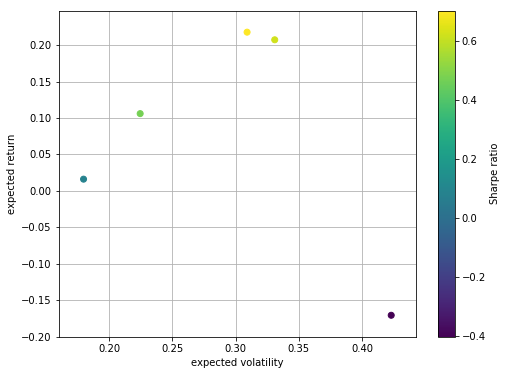

In [87]:
plt.figure(figsize=(8,6))
test_rets =[]
test_vols =[]
for i in range(noa):
    weights = np.zeros(noa)
    weights[i]=1.0
    stats = statistics(weights.tolist())
    print('Statistics for portfolio consisting only of',symbols[i])
    print(stats)
    test_rets.append(stats[0])
    test_vols.append(stats[1])
    
test_rets = np.array(test_rets)
test_vols = np.array(test_vols)
plt.scatter(test_vols,test_rets,c=test_rets/test_vols,marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.grid()

It's easy to match the securities with their respective points on the plot. As you can see, a portfolio of solely YHOO offers the highest expected return, however MSFT also offers a decent return at lower risk. 

Back to the problem of determining our efficient frontier. Next we need to define some functions to help us identify the quantities we want to minimize and maximize.

In [88]:
def min_func_sharpe(weights):
    # Function to minimize Sharpe value
    # Note we negate the value so that by minimizing we actually obtain the portfolio with the highest Sharpe value
    return -statistics(weights)[2]

def min_func_variance(weights):
    # function to minimize absolute variance
    return statistics(weights)[1]**2

Now we need to add bounds and contraints that will tell our optimization function what our portfolio contruction is limited by

In [89]:
# constraining that portfolio weights add up to 1
cons = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
# bound the weights between 0 and 1
bnds = tuple((0,1) for x in range(noa))

Now we're ready to call our optimization function. In this demo, we are using SciPy's optimize library, as it provides efficient and robust functions for our purposes. For an initial guess, we will simply use equal weights of all securities.

In [90]:
# highest sharp ratio portfolio
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
# absolute minimum variance portfolio
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
# note: using noa * [1. / noa,] as initial guess, even distribution of securities
print('Max Sharpe Value portfolio:\n', opts['x'], '\nWith Statistics:\n',statistics(opts['x']))
print('Minimum Variance Portfolio:\n', optv['x'], '\nWith Statistics:\n',statistics(optv['x']))

Max Sharpe Value portfolio:
 [0.2750632  0.17988045 0.41017891 0.         0.13487745] 
With Statistics:
 [0.16756104 0.20535167 0.81597116]
Minimum Variance Portfolio:
 [0.06254083 0.26403329 0.1083803  0.         0.56504558] 
With Statistics:
 [0.07357813 0.13613795 0.54046744]


The Max Sharpe value portfolio is contructed primarily (about 68%) of AMZN and YHOO. These two securities had very high returns over this time period, and these returns appear to dominate over the variance in the Sharpe Value calculation. The minimum variance portfolio is comprised mainly of GLD and MSFT, as these securities had the lowest variance over this time period while still producing positive returns. Note in both portfolios there is no investment in DB. This was the only security to have negative returns over this period, therefore it would not be considered as a valuable investment.

Now, to calculate our efficient frontier, we need to determine the portfolio with the lowest possible variance for each level of expected returns. This process is carried out in the following segment:

In [91]:
# create an array to hold all possible values of expected return
trets = np.linspace(0., np.max(prets), 50)
# create an array to hold minimum volatility at each value of returns
tvols = []
for tret in trets:
    # We need to modify our optimization constraints to force the algorithm to pick a portfolio that has the given
    # expeted return for this loop (first line), while still requiring the weights to add up to 1 (second line)
    cons = ({'type' : 'eq', 'fun' : lambda x: statistics(x)[0] - tret},
            {'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
    # for the minimzation, we use the same bounds on our weights as before, namely that each weight must be between
    # 0 and 1, inclusive
    res = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(np.sqrt(res['fun']))
tvols = np.array(tvols)

Let's visualize our opitmal portfolios as well as the efficient frontier.

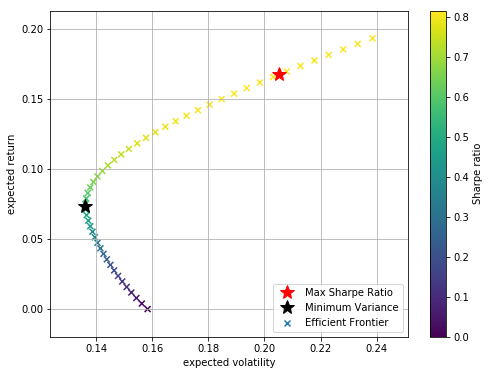

In [99]:
plt.figure(figsize=(8,6))
plt.scatter(tvols, trets, c=trets/tvols, marker='x') # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0) # highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'k*', markersize=15.0) # minimum variance
plt.grid()
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.legend(['Max Sharpe Ratio','Minimum Variance','Efficient Frontier'], loc=4)

As expected, both the minimum variance portfolio and the max Sharpe value portfolio are on the efficient frontier. According to Modern Portfolio Theory, any rational investor will choose a portfolio on the top half of the efficient frontier. A less risk-averse invester may choose a portfolio with higher expected return but higher risk, while a more risk-averse investor might choose a portfolio with less risk and more moderate expected return.

There is one more element that should be added into our basic market model, and that is the inclusion of a risk-free asset. Introducing a risk-free asset will add another element to our risk vs return plot, namely the capital market line (CML). This line shows all possible combinations of efficient risky portfolios along with investment or leveraging of the risk-free asset. 

In [93]:
# Get the top side of the efficient frontier, starting with the minimum variance portfolio
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]
# Create spline interpolation of the efficient frontier
tck = sci.splrep(evols, erets)

# Now we have a continuously defined and differentiable function for the efficient frontier.
def f(x):
    # Returns the EV on the efficient frontier for a given volatility, using spline interpolation
    return sci.splev(x, tck, der=0)

def df(x):
    # returns first derivative of spline interpolation of the efficient frontier, give a volatility
    return sci.splev(x, tck, der=1)

Graphically, the CML is defined as the linear function which has a risk-free return of a given risk-free rate, and lies tangent to the efficient frontier. Mathematically this can be represented by the following model:

Let rf = risk-free interest rate, f(x) = efficient frontier evaluated at volatility=x, df(x) = slope of efficient frontier evaluated at at.

We want:

t(x) = a + bx

s.t.

t(0) = rf -> a = rf

t(x) = f(x) at the x corresponding to the Market Portfolio -> a + bx = f(x)

t'(x) = df(x) at the x corresponding to the Market Portfolio -> b = df(x)

There will be one unique x-value for which all 3 of the above equations are true. We can create a function that will compute the difference between the right hand side of these equations and supplied values of (a, b, x), all equations going to 0 when the parameters of the tangency point are supplied.

In [94]:
# equations to determine the Capital Market Line
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

We can use the function fsolve to find the zeros of these equations, provided a reasonable guess. We already know the first parameter must be equal to the risk-free rate specified as 1% in the above function. By inspecting the plot of the efficient frontier we see that the slope appears to be close to 1. Finally, the point of tangency looks to be around a volatility of around 0.2. Let's plug this in and see what we get

In [95]:
opt = sco.fsolve(equations, [0.01, 1., .2])
print('CML params a, b, and point of tangency x:\n',opt)
print('Checking equations go to 0:\n',np.round(equations(opt),3))

CML params a, b, and point of tangency x:
 [0.01       0.76921383 0.22414767]
Checking equations go to 0:
 [ 0. -0. -0.]


These guesses were pretty close! We can see that the market portfolio has an expected variance of about 0.224. Plugging this back into our spline interpolation we can ge the corresponding expected returns.

In [96]:
print(f(opt[2]))

0.18241748684864936


So on the risk-return plot, our market portfolio is roughly at the coordinates (0.224, 0.182). If we want to find the corresponding asset weights that generate this portfolio, we will have to do some back-tracking. Since we know this portfolio is on the efficient frontier, we can set the constraints to limit maximum expected return to this optimal value, then find what weights minimize the variance.

In [101]:
cons = ({'type' : 'eq', 'fun' : lambda x: statistics(x)[0] - f(opt[2])},
        {'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
res = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
opt_weights = res['x']
print(opt_weights)
print(statistics(opt_weights))

[0.30611441 0.17539658 0.45636527 0.         0.06212374]
[0.18241749 0.22414767 0.81382727]


The Market Portfolio consists of 4 of the 5 securities we have analyzed, and we can see by checking the statistics the expected return and expected variance agree with the previously calculated values.

Let's create a visualization combining all of the analysis we've done so far. We'll scatter the randomly generated portfolios, plot the efficient frontier, and plot the CML, indicating the location of the Market Portfolio.

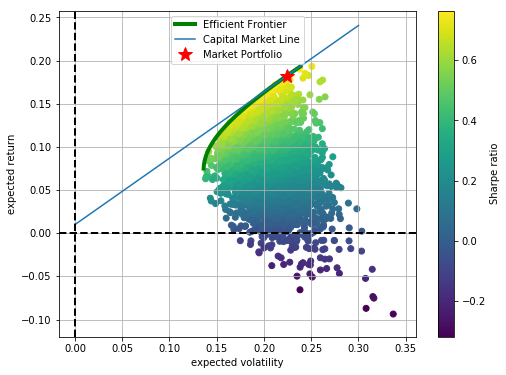

In [102]:
plt.figure(figsize=(8,6))
plt.scatter(pvols, prets, c=(prets - 0.01)/pvols, marker='o') # random compositions
plt.plot(evols, erets, 'g', lw=4.)
cx = np.linspace(0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
plt.plot(opt[2],f(opt[2]), 'r*', markersize=15.)
plt.grid()
plt.axhline(0, color='k', ls='--', lw=2.)
plt.axvline(0, color='k', ls='--', lw=2.)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.legend(['Efficient Frontier','Capital Market Line','Market Portfolio'])

Just a few more notes on the CML and Market Portfolio. The Market Portfolio is effectively the optimal portfolio in terms of providing the most diversified possible portfolio. It is theoretically the choice that the any rational investor would make, given the assumptions we have made. If we could consider borrowing or lending of the risk free asset, we could construct a portfolio anywhere along the CML, as our portfolio construction would not be limited to have to add up to all of our buying power. 

All of this analysis is bundled withing the Capital Asset Pricing Model (CAPM), which has some shortcomings. First off, an asset's historical volatility is not always the best measure of "risk," or how it will perform in the future. Additionally it is difficult to model the "market" as a whole. Rather, the performance of a portfolio can be compared to that of a major stock index, such as the S&P 500 or the Dow Jones Index. Finally the model assumes asset prices and variances to be normally distributed, which has been shown to be not quite true.

While having its flaws, the CAPM, CML, and Market Portfolio are useful baseline tools to get a general idea of how a portfolio has historically performed when compared to the overall market.